# Bird Image Classification Project

In [1]:
#importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from pymongo import MongoClient
from gridfs import GridFS
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten 
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2

In [2]:
#function to upload a data to MongoDB
def upload_data(folder_path, db, fs, parent_folder_name=""):
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            with open(file_path, 'rb') as image_file:
                #including the parent folder name in the filename
                if parent_folder_name:
                    filename = os.path.join(parent_folder_name, file_name)
                else:
                    filename = file_name
                fs.put(image_file.read(), filename=filename)

In [3]:
#establishing connection to MongoDB
mongodb_client = MongoClient("mongodb://localhost:27017")

#creating database in the mongodb
bird_db = mongodb_client["Project_set_2"]
bird_imgs = GridFS(bird_db, collection="bird_images")

In [4]:
#local path of the dataset to upload data to mongodb
local_data = "/Users/avss/Desktop/DATA_603/Project/500"

#uploading data to MongoDB
for subfolder_name in os.listdir(local_data):
    subfolder_path = os.path.join(local_data, subfolder_name)
    if os.path.isdir(subfolder_path):
        print(f"Uploading images from {subfolder_name}...")
        upload_data(subfolder_path, db=bird_db, fs=bird_imgs, parent_folder_name=subfolder_name)

#image uploading status completion confirmation
print("All images uploaded to MongoDB Sucessfully........ ")

Uploading images from Coppersmith-Barbet...
Uploading images from Cattle-Egret...
Uploading images from Common-Myna...
Uploading images from Sarus-Crane...
Uploading images from Common-Kingfisher...
Uploading images from House-Crow...
Uploading images from Forest-Wagtail...
Uploading images from Indian-Peacock...
Uploading images from Indian-Grey-Hornbill...
Uploading images from Indian-Roller...
All images uploaded to MongoDB Sucessfully........ 


In [5]:
#initilizing the empty list to store the loaded data from MongoDB
bird_dataset = []

#specifying the categories of birds in our dataset
birds_categories = [
    "Coppersmith-Barbet",
    "Cattle-Egret",
    "Common-Myna",
    "Sarus-Crane",
    "Common-Kingfisher",
    "House-Crow",
    "Forest-Wagtail",
    "Indian-Peacock",
    "Indian-Grey-Hornbill",
    "Indian-Roller"
]

#iterating through each bird category
for category in birds_categories:
    print(f"Reading images from {category}...")

    #finding images with filenames matching the category
    images_cursor = bird_imgs.find({"filename": {"$regex": category}})

    #iterating through each document in the category
    for document in images_cursor:
        #skiping .DS_Store files as they are not images
        if document.filename.endswith(".DS_Store"):
            #print(f"Skipping {document.filename}...")
            continue

        #loading the image using OpenCV
        image_data = bird_imgs.get(document._id).read()
        img_opencv = cv2.imdecode(np.frombuffer(image_data, np.uint8), cv2.IMREAD_COLOR)

        #checking if the image is empty and continuning if the image is empty
        if img_opencv is None:
            print(f"Warning: Image in {document.filename} is empty.")
            continue

        #resize the all images to a fixed size
        img_opencv = cv2.resize(img_opencv, (224, 224))

        #flatten the image into a 1D array
        flattened_image = img_opencv.flatten()

        #appending the flattened image, label in a tuple format to the dataset
        bird_dataset.append((flattened_image, category))

Reading images from Coppersmith-Barbet...
Reading images from Cattle-Egret...
Reading images from Common-Myna...
Reading images from Sarus-Crane...
Reading images from Common-Kingfisher...
Reading images from House-Crow...
Reading images from Forest-Wagtail...
Reading images from Indian-Peacock...
Reading images from Indian-Grey-Hornbill...
Reading images from Indian-Roller...


In [6]:
#checking the length of the dataset to know how many images are there in db
len(bird_dataset)

500

In [7]:
#converting the list of tuples to a pandas DataFrame
columns = ["image", "label"]
labeled_df = pd.DataFrame(bird_dataset, columns=columns)

#displaying the top 5 rows of our dataframe
labeled_df.head(5)

,image,label
0,"[250, 209, 177, 249, 208, 176, 248, 207, 175, ...",Coppersmith-Barbet
1,"[192, 178, 160, 206, 178, 156, 145, 137, 135, ...",Coppersmith-Barbet
2,"[124, 138, 144, 123, 139, 146, 123, 140, 149, ...",Coppersmith-Barbet
3,"[107, 154, 181, 120, 160, 183, 162, 195, 214, ...",Coppersmith-Barbet
4,"[49, 110, 100, 44, 106, 96, 49, 110, 100, 47, ...",Coppersmith-Barbet


In [8]:
#converting a list of pixel values from bird dataframe to a 3D NumPy array for plotting
def list_to_array(pixel_values):
    return np.array(pixel_values).reshape(224, 224, 3)

# Displaying the sample images

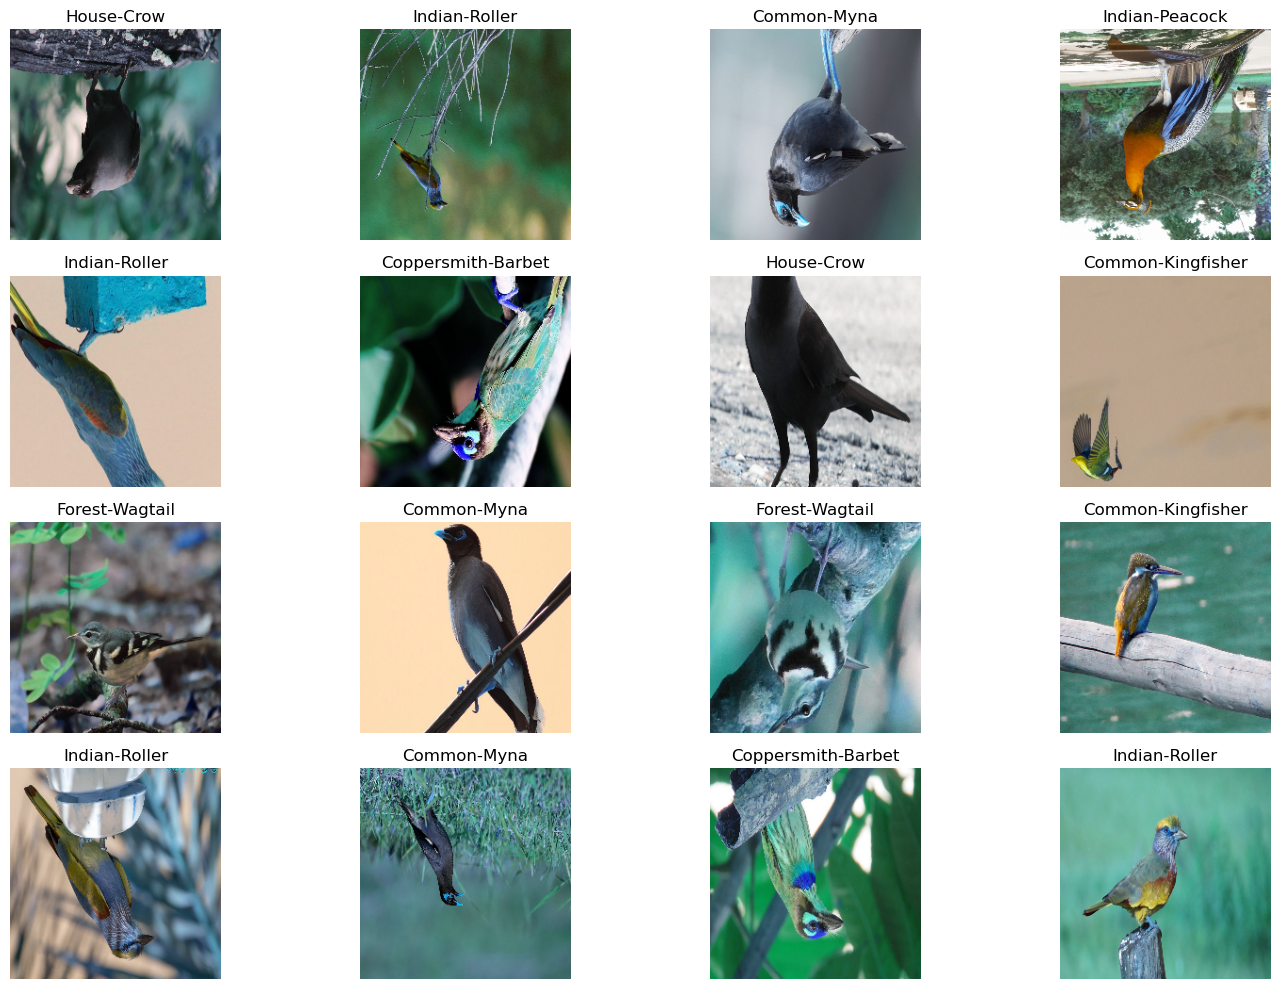

In [9]:
#selecting a random sample of images for plotting
sample_df = labeled_df.sample(n=16)

#ploting the sample images with labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

for i, (index, row) in enumerate(sample_df.iterrows()):
    image_array = list_to_array(row['image'])
    axes[i // 4, i % 4].imshow(image_array)
    axes[i // 4, i % 4].set_title(row['label'])
    axes[i // 4, i % 4].axis('off')

plt.tight_layout()

#displaying the images
plt.show()

In [10]:
#converting the categorical labels to integers
label_mapping = {category: i for i, category in enumerate(birds_categories)}

#displaying the label mapping
print(label_mapping)

#updating the label column in the dataframe with above converted numerical values
labeled_df['label'] = labeled_df['label'].map(label_mapping)

{'Coppersmith-Barbet': 0, 'Cattle-Egret': 1, 'Common-Myna': 2, 'Sarus-Crane': 3, 'Common-Kingfisher': 4, 'House-Crow': 5, 'Forest-Wagtail': 6, 'Indian-Peacock': 7, 'Indian-Grey-Hornbill': 8, 'Indian-Roller': 9}


# Displaying the sample images with numberical labels

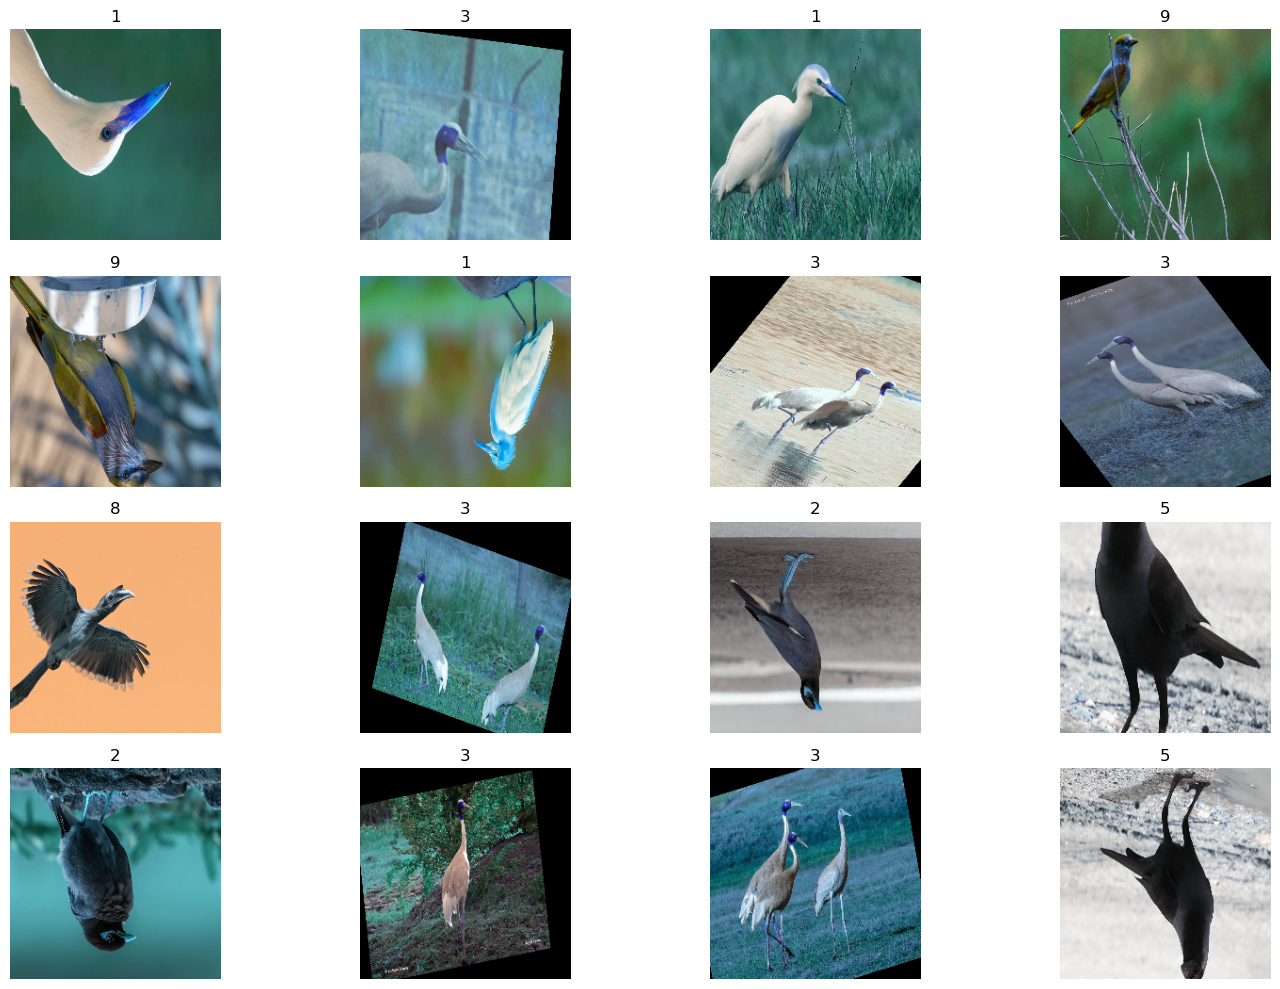

In [11]:
#selecting a random sample of images for plotting
sample_df = labeled_df.sample(n=16)

#ploting the sample images with labels
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

for i, (index, row) in enumerate(sample_df.iterrows()):
    image_array = list_to_array(row['image'])
    axes[i // 4, i % 4].imshow(image_array)
    axes[i // 4, i % 4].set_title(row['label'])
    axes[i // 4, i % 4].axis('off')

plt.tight_layout()

#displaying the images
plt.show()

In [12]:
#preprocess the images by performing the normalization
labeled_df['image'] = labeled_df['image'].apply(lambda x: np.array(x) / 255.0)

#spliting the data into training and testing sets with 70 and 30 split
X_train, X_test, y_train, y_test = train_test_split(
    np.array(labeled_df['image'].tolist()),
    labeled_df['label'].values,
    test_size=0.3,
    random_state=42
)

# Building an CNN model 

In [13]:
#importing tensorflow_addons library
import tensorflow_addons as tfa

#reshaping the images to (224, 224, 3) to match input
X_train = X_train.reshape((-1, 224, 224, 3))
X_test = X_test.reshape((-1, 224, 224, 3))

#defining the categories
birds_categories = labeled_df['label'].unique()

#creating a CNN model
def create_cnn_model(n_filter, ker, learning_rate):
    model = Sequential()

    #using the VGG16 transfer learning model
    vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    vgg_model.trainable = False

    # Custom head
    model.add(vgg_model)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(birds_categories), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy', tfa.metrics.F1Score(num_classes=1, average='micro')])

    return model

#building the model
model = create_cnn_model(n_filter=16, ker=(3, 3), learning_rate=0.001)

#displaying the model summary
model.summary()


/Users/avss/anaconda3/lib/python3.11/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 17927370 (68.39 MB)
Trainable params: 3212682 (12.26 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
)


model_history = model.fit(datagen.flow(X_train, y_train, batch_size=32), steps_per_epoch=len(X_train) // 32, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
10/10 [==============================] - 42s 4s/step - loss: 5.2585 - accuracy: 0.1730 - f1_score: 0.1957 - val_loss: 2.8059 - val_accuracy: 0.2667 - val_f1_score: 0.1955
Epoch 2/30
10/10 [==============================] - 44s 5s/step - loss: 1.8410 - accuracy: 0.4151 - f1_score: 0.1957 - val_loss: 1.6939 - val_accuracy: 0.4333 - val_f1_score: 0.1955
Epoch 3/30
10/10 [==============================] - 45s 5s/step - loss: 1.1773 - accuracy: 0.6667 - f1_score: 0.1956 - val_loss: 1.5176 - val_accuracy: 0.5200 - val_f1_score: 0.1955
Epoch 4/30
10/10 [==============================] - 45s 5s/step - loss: 0.8305 - accuracy: 0.7799 - f1_score: 0.1957 - val_loss: 1.2599 - val_accuracy: 0.6067 - val_f1_score: 0.1955
Epoch 5/30
10/10 [==============================] - 45s 5s/step - loss: 0.6199 - accuracy: 0.8365 - f1_score: 0.1957 - val_loss: 1.0782 - val_accuracy: 0.6733 - val_f1_score: 0.1955
Epoch 6/30
10/10 [==============================] - 45s 5s/step - loss: 0.4417 - accuracy:

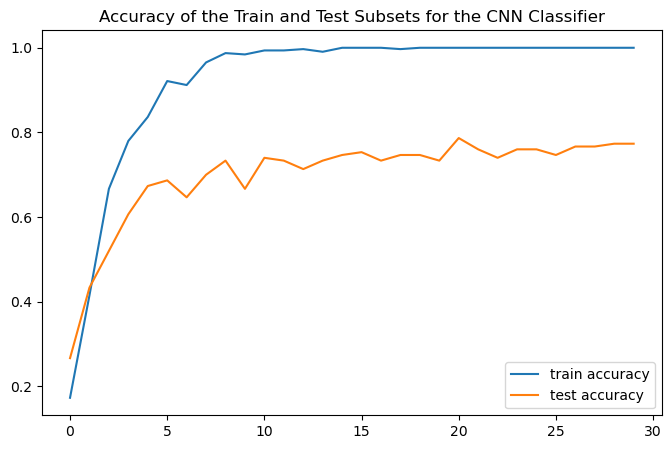

In [15]:
#plotting accuracy score graph for test and train
plt.figure(figsize=(8,5))
plt.plot(model_history.history['accuracy'], label = 'train accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'test accuracy') 
plt.title('Accuracy of the Train and Test Subsets for the CNN Classifier')
plt.legend(['train accuracy', 'test accuracy'])
plt.show()

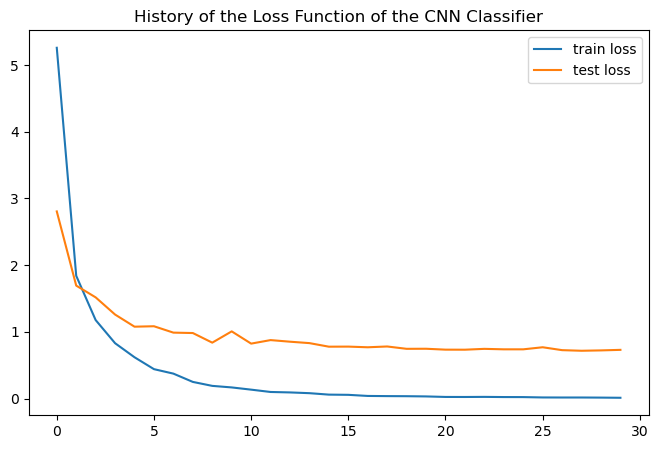

In [16]:
#plotting loss function graph for test and train
plt.figure(figsize=(8,5))
plt.plot(model_history.history['loss'], label = 'train loss')
plt.plot(model_history.history['val_loss'], label = 'test loss') 
plt.title('History of the Loss Function of the CNN Classifier')
plt.legend(['train loss', 'test loss'])
plt.show()

5/5 [==============================] - 17s 3s/step


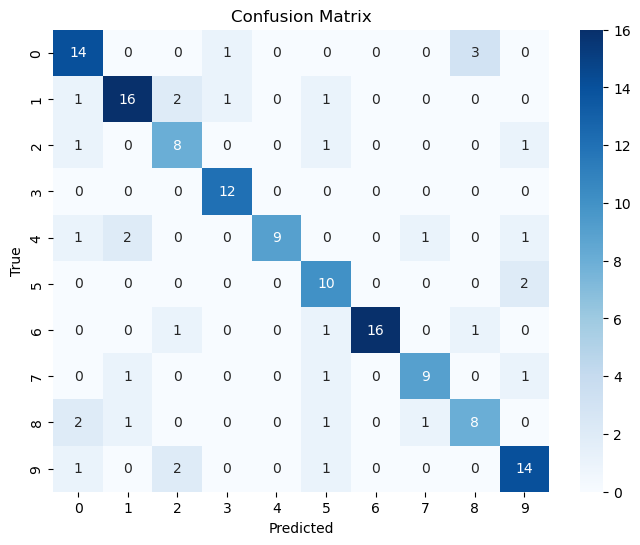

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74        18
           1       0.80      0.76      0.78        21
           2       0.62      0.73      0.67        11
           3       0.86      1.00      0.92        12
           4       1.00      0.64      0.78        14
           5       0.62      0.83      0.71        12
           6       1.00      0.84      0.91        19
           7       0.82      0.75      0.78        12
           8       0.67      0.62      0.64        13
           9       0.74      0.78      0.76        18

    accuracy                           0.77       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.79      0.77      0.78       150



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#converting the numeric labels to strings
birds_categories_str = [str(label) for label in birds_categories]


#predicting on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

#confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

#ploting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=birds_categories, yticklabels=birds_categories)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#classification report
class_report = classification_report(y_test, y_pred_classes, target_names=birds_categories_str)
print("Classification Report:\n", class_report)

# Validating the model

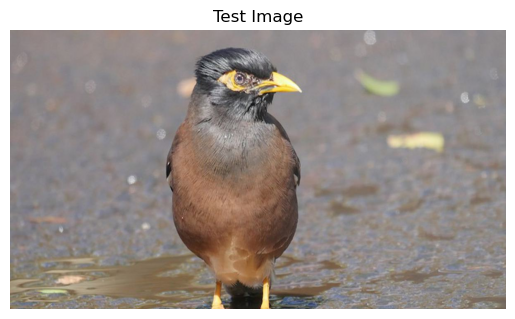

In [18]:
#loading the test images for validating
image_path = "/Users/avss/Desktop/DATA_603/Project/Dataset/Test/Common-Myna/Common-Myna_282.jpg"
test_img = cv2.imread(image_path)

#displaying the test image
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title("Test Image")
plt.axis("off")
plt.show()

In [19]:
#if we don't have any image
if test_img is None:
    print("Error: Unable to load the image.")
else:
    #resizing to match the input shape for the model
    img = cv2.resize(test_img, (224, 224))
    img = img / 255.0
    img = img.reshape(1, 224, 224, 3)

    #making the prediction using the above trained model
    prediction = model.predict(img)

    #displaying the predicted class
    predicted_class = np.argmax(prediction)
    print("Predicted Class:", predicted_class)

1/1 [==============================] - 0s 107ms/step
Predicted Class: 2


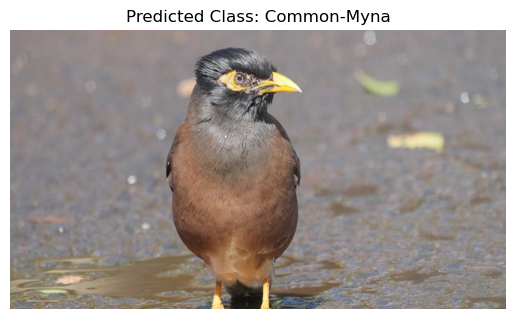

In [20]:
#numerical classes to category class mapping
class_names = {
    0: 'Coppersmith-Barbet',
    1: 'Cattle-Egret',
    2: 'Common-Myna',
    3: 'Sarus-Crane',
    4: 'Common-Kingfisher',
    5: 'House-Crow',
    6: 'Forest-Wagtail',
    7: 'Indian-Peacock',
    8: 'Indian-Grey-Hornbill',
    9: 'Indian-Roller'
}

#displaying the label for the above predicted class
predicted_class_name = class_names[predicted_class]


#displaying the test image with the predicted label
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted Class: {predicted_class_name}")
plt.axis("off")
plt.show()